#**Data overview**

---


This notebook focuses on understanding the structure and key characteristics of the 3D CT dataset used for aortic segmentation. The dataset consists of **56 CT scans**, divided into **three subsets**, each sourced from a different hospital. This diversity introduces valuable domain variation and supports the development of more robust and generalizable models. In addition to analyzing volume shapes and voxel intensity distributions, it includes **background value unification** across volumes — an essential step to ensure consistency before further processing. It does not perform intensity normalization or segmentation-related tasks, which are handled in later stages of the project.


---



The first step in the analysis is to import the necessary libraries that support file handling, data processing, visualization, and medical image reading:

- `matplotlib.pyplot` — used to generate plots,
- `os` — used to navigate through the dataset directory and access image files,
- `SimpleITK` — a specialized library for reading and processing medical images, here used to load CT volumes  (`.nrrd` format),
- `numpy` — for performing numerical operations on the image data represented as arrays,
- `pandas` — for organizing and storing summary statistics in structured dataframes.

**Note:** The `!pip install SimpleITK` command is included for compatibility with Google Colab, where `SimpleITK` is not available by default.

In [1]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 41.3 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd

**File paths**

---


In this step, we gather the full paths to all CT image files (in `.nrrd` format) from the dataset directory structure, by using function `get_files_path()` that:
- Iterates through the subdirectories of a given dataset folder,
- Filters for files ending with `.nrrd`,
- Ignores segmentation mask files (which follow the `.seg.nrrd` naming convention),
- Returns a list of file paths for raw CT volumes only.


 **Note:** Be sure to update the `Data_path` variable to match the location of your dataset folder on your system or cloud environment.

In [3]:
def get_files_path(data_path, folder):
    names = []
    folder_path = os.path.join(data_path, folder)
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        for file in os.listdir(subfolder_path):
            if file.endswith(".nrrd") and not file.endswith(".seg.nrrd"):
                names.append(os.path.join(subfolder_path, file))
    return names

Data_path = r"/content/drive/MyDrive/Aorta_Segmentation/Data"

Dongyang_data_names = get_files_path(Data_path, "Dongyang")
KiTS_data_names = get_files_path(Data_path, "KiTS")
Rider_data_names = get_files_path(Data_path, "Rider")

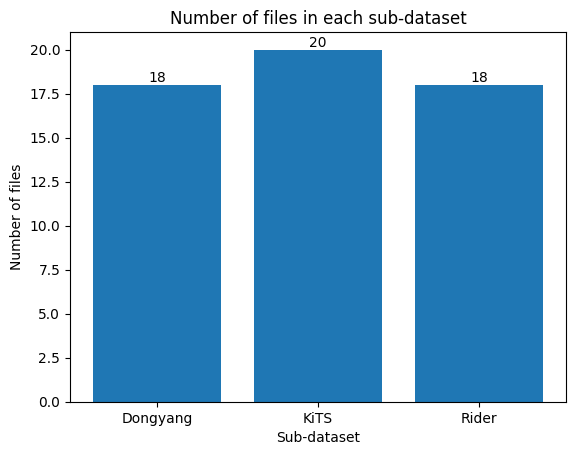

In [4]:
names = ["Dongyang", "KiTS", "Rider"]
n_files = [len(Dongyang_data_names), len(KiTS_data_names), len(Rider_data_names)]

plt.figure(dpi=100)
plt.bar(names, n_files)
for i, n in enumerate(n_files):
    plt.text(i, n, str(n), ha='center', va='bottom')
plt.title("Number of files in each sub-dataset")
plt.xlabel("Sub-dataset")
plt.ylabel("Number of files")
plt.show()

**Getting slices**


---


Since the model will operate on 2D slices extracted from 3D CT volumes, it's important to understand how many slices are present in each scan — and how this varies between datasets.

In this step:

- We define a helper function `get_slice_amount()` that reads each 3D image and extracts the number of slices along the axial (Z) axis.
- We apply this function to all three sub-datasets.
- Then, we visualize:
  - The **total number of slices** in each sub-dataset using a bar chart,
  - The **distribution of slice counts per scan** using histograms.

**Note:** The `.T` operation is used to reorient the 3D array for consistent axis handling.

In [5]:
def get_slices(data_names):
  lst_slices = []
  for name in data_names:
    image = sitk.ReadImage(name) #(Z, Y, X)
    image = sitk.GetArrayFromImage(image).T #(X, Y, Z)
    lst_slices.append(image.shape[2])
  return lst_slices

Dongyang_lst_slices = get_slices(Dongyang_data_names)
KiTS_lst_slices = get_slices(KiTS_data_names)
Rider_lst_slices  = get_slices(Rider_data_names)

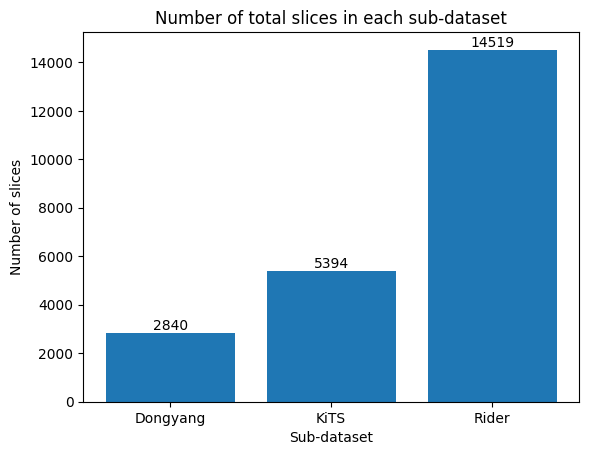

In [6]:
names = ["Dongyang", "KiTS", "Rider"]
n_slices = [sum(Dongyang_lst_slices), sum(KiTS_lst_slices), sum(Rider_lst_slices)]

plt.figure(dpi=100)
plt.bar(names, n_slices)
for i, n in enumerate(n_slices):
    plt.text(i, n, str(n), ha='center', va='bottom')
plt.title("Number of total slices in each sub-dataset")
plt.xlabel("Sub-dataset")
plt.ylabel("Number of slices")
plt.show()

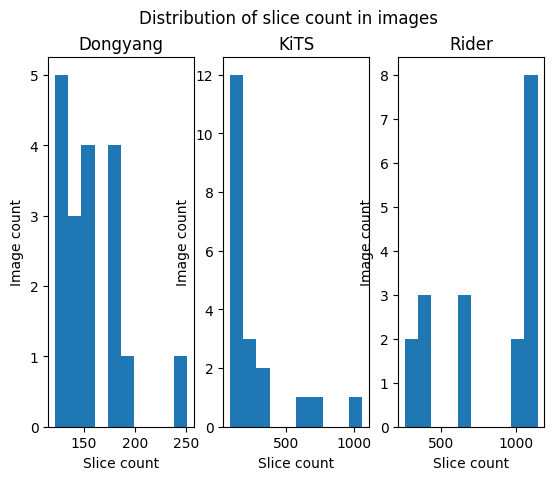

In [7]:
plt.figure(dpi=100)
plt.suptitle("Distribution of slice count in images")

plt.subplot(1, 3, 1)
plt.hist(Dongyang_lst_slices, bins=10)
plt.title("Dongyang")
plt.xlabel("Slice count")
plt.ylabel("Image count")

plt.subplot(1, 3, 2)
plt.hist(KiTS_lst_slices, bins=10)
plt.title("KiTS")
plt.xlabel("Slice count")
plt.ylabel("Image count")

plt.subplot(1, 3, 3)
plt.hist(Rider_lst_slices, bins=10)
plt.title("Rider")
plt.xlabel("Slice count")
plt.ylabel("Image count")

plt.show()

**Getting voxels**

---

In this section, we analyze the **distribution of voxel intensities** across the three sub-datasets.

To do this:

- We first load each 3D CT volume into memory using the `get_images3D()` function.
  - The function returns a list of 3D NumPy arrays (one per scan),
  - Note: We retain the full 3D data structure instead of flattening immediately, since these arrays may be reused in later steps (e.g., for visualization or preprocessing).
- Next, we extract voxel values from each dataset and flatten them into 1D arrays for histogram analysis.
- Finally, we plot the **log-scaled histograms** of voxel intensities for each sub-dataset separately.

These plots help us understand the dynamic range and distribution of voxel values across sources, which is critical for later normalization and model training.

In [8]:
def get_images3D(data_names):
  lst = []
  for name in data_names:
    image = sitk.ReadImage(name)
    image = sitk.GetArrayFromImage(image).T
    lst.append(image)
  return lst

Dongyang_3d_lst = get_images3D(Dongyang_data_names)
KiTS_3d_lst = get_images3D(KiTS_data_names)
Rider_3d_lst = get_images3D(Rider_data_names)

Dongyang_voxels = np.concatenate([obj.flatten() for obj in Dongyang_3d_lst])
KiTS_voxels = np.concatenate([obj.flatten() for obj in KiTS_3d_lst])
Rider_voxels = np.concatenate([obj.flatten() for obj in Rider_3d_lst])

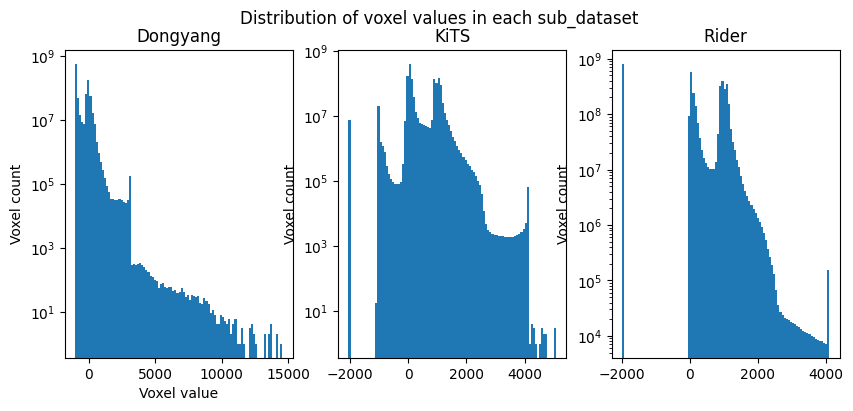

In [9]:
plt.figure(figsize=(10, 4))
plt.suptitle("Distribution of voxel values in each sub_dataset")

plt.subplot(1, 3, 1)
plt.hist(Dongyang_voxels, bins=100)
plt.yscale('log')
plt.title("Dongyang")
plt.xlabel("Voxel value")
plt.ylabel("Voxel count")

plt.subplot(1, 3, 2)
plt.hist(KiTS_voxels, bins=100)
plt.yscale('log')
plt.title("KiTS")
plt.ylabel("Voxel count")

plt.subplot(1, 3, 3)
plt.hist(Rider_voxels, bins=100)
plt.yscale('log')
plt.title("Rider")
plt.ylabel("Voxel count")

plt.show()

**Inspecting background intensity values on volume borders**


---


The histograms plotted in the previous step revealed inconsistencies in the range of voxel intensities — particularly in the low-value region, which is typically associated with background.

To address this, we first investigate the **border voxels** , since background regions are most likely to appear at the periphery of medical scans.

- We define a function `get_background_values()` that:
  - Inspects the six outer faces (left, right, front, back, top, bottom) of each 3D image,
  - Extracts the **minimum unique voxel value** from each face,
  - Collects this information into a `DataFrame`, which allows for easy inspection and comparison.

This step helps verify whether background values are consistent across images and sub-datasets. If not, it motivates the need for **background unification**.

In [14]:
def get_background_values(image3d_lst):
    records = []
    for idx, array in enumerate(image3d_lst):
        data_info = {
            'left': np.min(np.unique(array[0, :, :])),
            'right': np.min(np.unique(array[-1, :, :])),
            'front': np.min(np.unique(array[:, 0, :])),
            'back': np.min(np.unique(array[:, -1, :])),
            'top': np.min(np.unique(array[:, :, 0])),
            'bottom': np.min(np.unique(array[:, :, -1])),
        }
        records.append(data_info)
    df = pd.DataFrame(records)
    return df

print(f"Dongyang: \n{get_background_values(Dongyang_3d_lst)}\n")
print(f"KiTS: \n{get_background_values(KiTS_3d_lst)}\n")
print(f"Rider: \n{get_background_values(Rider_3d_lst)}\n")

Dongyang: 
    left  right  front  back   top  bottom
0  -1024  -1024  -1024 -1024 -1024   -1024
1  -1024  -1024  -1024 -1024 -1024   -1024
2  -1024  -1024  -1024 -1024 -1024   -1024
3  -1024  -1024  -1024 -1024 -1024   -1024
4  -1024  -1024  -1024 -1024 -1024   -1024
5  -1024  -1024  -1024 -1024 -1024   -1024
6  -1024  -1024  -1024 -1024 -1024   -1024
7  -1024  -1024  -1024 -1024 -1024   -1024
8  -1024  -1024  -1024 -1024 -1024   -1024
9  -1024  -1024  -1024 -1024 -1024   -1024
10 -1024  -1024  -1024 -1024 -1024   -1024
11 -1024  -1024  -1024 -1024 -1024   -1024
12 -1024  -1024  -1024 -1024 -1024   -1024
13 -1024  -1024  -1024 -1024 -1024   -1024
14 -1024  -1024  -1024 -1024 -1024   -1024
15 -1024  -1024  -1024 -1024 -1024   -1024
16 -1024  -1024  -1024 -1024 -1024   -1024
17 -1024  -1024  -1024 -1024 -1024   -1024

KiTS: 
     left  right  front   back    top bottom
0       0      0      0      0      0      0
1       0      0      0      0      0      0
2       0      0      0      

**Background normalization**


---

After identifying background value inconsistencies across datasets, we now **visually inspect the effect of background unification** using example slices from each sub-dataset.

- We extract one representative 2D slice from a volume in each dataset:
  - **Dongyang:** one axial slice, **cropped spatially** to match the dimensions of other slices,
  - **KiTS & Rider:** full slice at a specific depth.
- We visualize:
  1. The original slices with raw intensity values (top row),
  2. The same slices after applying background unification strategies:
   - **Strategy 1 – Clipping negative values:**  
  Negative voxel values (typically associated with background) were clipped to `0`. This worked reasonably well for **KiTS** and **Rider**, but **in Dongyang it removed meaningful anatomical features** — as some organ structures appeared to have negative intensity values.
  
   - **Strategy 2 – Value offset (+1024):**  
  To preserve the original intensity relationships in Dongyang volumes, we instead added a constant value of **+1024** to all voxels. This preserved relative contrast and resolved background inconsistencies without removing anatomical details.

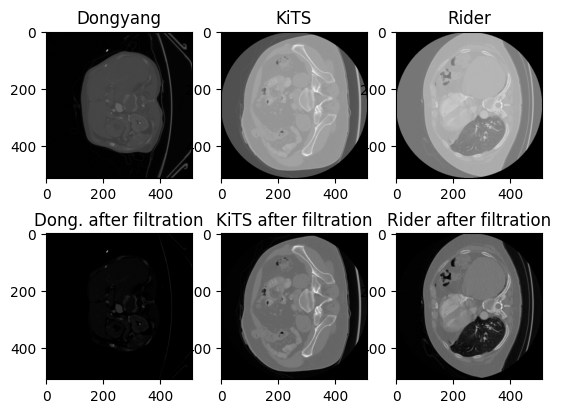

In [11]:
D_slice = Dongyang_3d_lst[0][:, 77:589, 130]
K_slice = KiTS_3d_lst[17][:, :, 80]
R_slice = Rider_3d_lst[2][:, :, 500]

plt.figure(dpi=100)
plt.subplot(2, 3, 1)
plt.imshow(D_slice, cmap="gray")
plt.title("Dongyang")
plt.subplot(2, 3, 2)
plt.imshow(K_slice, cmap="gray")
plt.title("KiTS")
plt.subplot(2, 3, 3)
plt.imshow(R_slice, cmap="gray")
plt.title("Rider")

D_filtered = D_slice.copy() #We use .copy() to make an explicit copy of the original slice to avoid modifying the original array by reference.
K_filtered = K_slice.copy()
R_filtered = R_slice.copy()
D_filtered[D_filtered < 0] = 0
K_filtered[K_filtered < 0] = 0
R_filtered[R_filtered < 0] = 0

plt.subplot(2, 3, 4)
plt.imshow(D_filtered, cmap="gray")
plt.title("Dong. after filtration")
plt.subplot(2, 3, 5)
plt.imshow(K_filtered, cmap="gray")
plt.title("KiTS after filtration")
plt.subplot(2, 3, 6)
plt.imshow(R_filtered, cmap="gray")
plt.title("Rider after filtration")

plt.show()

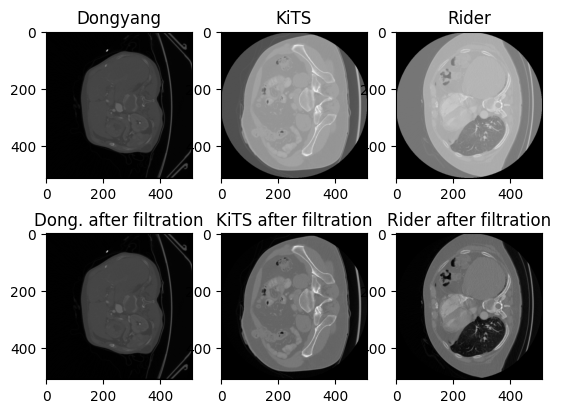

In [12]:
D_slice = Dongyang_3d_lst[0][:, 77:589, 130]
K_slice = KiTS_3d_lst[17][:, :, 80]
R_slice = Rider_3d_lst[2][:, :, 500]

plt.figure(dpi=100)
plt.subplot(2, 3, 1)
plt.imshow(D_slice, cmap="gray")
plt.title("Dongyang")
plt.subplot(2, 3, 2)
plt.imshow(K_slice, cmap="gray")
plt.title("KiTS")
plt.subplot(2, 3, 3)
plt.imshow(R_slice, cmap="gray")
plt.title("Rider")

D_filtered_2 = D_slice.copy()
D_filtered_2 += 1024

plt.subplot(2, 3, 4)
plt.imshow(D_filtered_2, cmap="gray")
plt.title("Dong. after filtration")
plt.subplot(2, 3, 5)
plt.imshow(K_filtered, cmap="gray")
plt.title("KiTS after filtration")
plt.subplot(2, 3, 6)
plt.imshow(R_filtered, cmap="gray")
plt.title("Rider after filtration")

plt.show()

**Voxel distribution after background unification**


---


In this final step, we **re-plot the voxel intensity histograms** for all three sub-datasets after applying the chosen background unification strategies:

- **Dongyang:** All voxel values shifted by +1024.
- **KiTS & Rider:** All negative values clipped to 0.

The updated histograms show that **background values have been successfully standardized**, removing irregular low-value peaks and increasing consistency across datasets.

However, it's also clear that:
- **Overall voxel intensity ranges still differ significantly** between sub-datasets,
- These differences reflect varying scanner settings, contrast levels, and acquisition protocols.

**Next step:** These disparities will be addressed during the **dedicated preprocessing stage**, where intensity normalization techniques will be applied to bring all volumes onto a common scale suitable for deep learning.

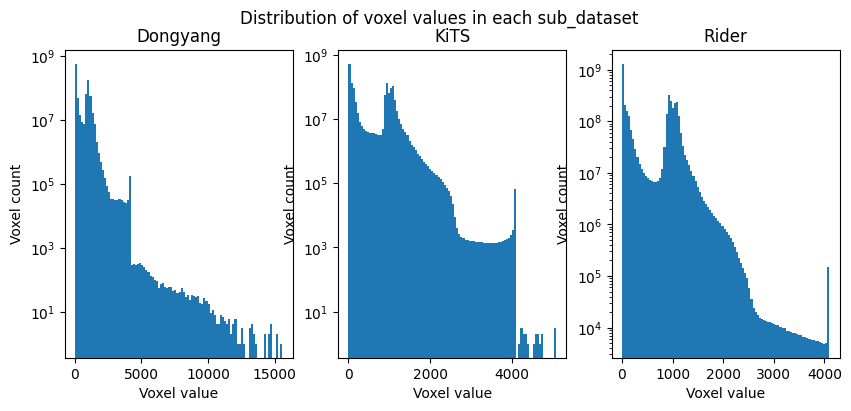

In [13]:
Dongyang_voxels += 1024
KiTS_voxels [KiTS_voxels<0] = 0
Rider_voxels [Rider_voxels<0] = 0

plt.figure(figsize=(10, 4))
plt.suptitle("Distribution of voxel values in each sub_dataset")

plt.subplot(1, 3, 1)
plt.hist(Dongyang_voxels, bins=100)
plt.yscale('log')
plt.title("Dongyang")
plt.xlabel("Voxel value")
plt.ylabel("Voxel count")

plt.subplot(1, 3, 2)
plt.hist(KiTS_voxels, bins=100)
plt.yscale('log')
plt.title("KiTS")
plt.xlabel("Voxel value")
plt.ylabel("Voxel count")

plt.subplot(1, 3, 3)
plt.hist(Rider_voxels, bins=100)
plt.yscale('log')
plt.title("Rider")
plt.xlabel("Voxel value")
plt.ylabel("Voxel count")

plt.show()